# Airbnb Queries

In [64]:
import pandas as pd
from cassandra.cluster import Cluster
cluster = Cluster(['127.0.0.1'])
session = cluster.connect('my_keyspace')

# Query 1:  List available Portland listings for a 2-day period, sorted by rating

In [63]:
query1 = "SELECT id FROM listings WHERE city = 'Portland' ALLOW FILTERING"
portland_listings = session.execute(query1)
portland_listing_ids = [row.id for row in portland_listings]

date_range = ["2025-07-15", "2025-07-16"]

available_listings = []
for listing_id in portland_listing_ids:
    is_available = True
    
    for date_str in date_range:
        query2 = "SELECT available FROM calendar WHERE listing_id = %s AND date = %s"
        result = session.execute(query2, (listing_id, date_str))
        row = result.one()
        if not row or not row.available:
            is_available = False
            break
    
    if is_available:
        available_listings.append(listing_id)

listing_details = []
for listing_id in available_listings:
    query3 = """SELECT id, name, room_type, accommodates, property_type, price, review_scores_rating, city, neighbourhood 
                FROM listings WHERE id = %s"""
    result = session.execute(query3, (listing_id,))
    row = result.one()
    if row:
        listing_details.append({
            'listing_id': row.id,
            'name': row.name,
            'city': row.city,
            'neighborhood': row.neighbourhood,
            'room_type': row.room_type,
            'accommodates': row.accommodates if hasattr(row, 'accommodates') else None,
            'property_type': row.property_type,
            'price': float(row.price) if row.price else 0,
            'review_scores_rating': float(row.review_scores_rating) if row.review_scores_rating else 0
        })

results_df = pd.DataFrame(listing_details)
if not results_df.empty:
    results_df = results_df.sort_values(by='review_scores_rating', ascending=False)
    display(results_df)
else:
    print("Nope")

,listing_id,name,city,neighborhood,room_type,accommodates,property_type,price,review_scores_rating
1383,680519123710389248,Sunny corner w/ open floor plan,Portland,Piedmont,Entire home/apt,4,Entire rental unit,93.0,5.0
1891,1268201952297658624,Luxury downtown condo in the pearl,Portland,Pearl,Entire home/apt,4,Entire rental unit,110.0,5.0
1908,40122072,Charming home in safe beautiful area - fenced ...,Portland,Northwest Heights,Entire home/apt,9,Entire home,300.0,5.0
557,23609556,Bright House-share with Private Bath Near Airport,Portland,Roseway,Private room,4,Private room in home,90.0,5.0
1904,984287915670628608,Play&Work in Southwest Portland,Portland,South Portland,Entire home/apt,4,Entire home,999.0,5.0
...,...,...,...,...,...,...,...,...,...
1589,1208048856128418304,Cozy Mt Tabor Cottage!,Portland,Mt. Tabor,Entire home/apt,2,Entire home,90.0,0.0
272,958750368664910208,Private room in Overlook,Portland,Overlook,Private room,1,Private room in home,60.0,0.0
1581,831129344738314880,Wyndham Portland Waterfront Park Resort | 1BR/1BA,Portland,Portland Downtown,Entire home/apt,4,Entire condo,796.0,0.0
777,1164555353538642176,3 BDR Perfect for Extended Stays Pet Friendly,Portland,Powellhurst-Gilbert,Entire home/apt,6,Entire home,160.0,0.0


# Query 2: Neighborhoods with no listings in a given month

In [ ]:
all_cities = ["Portland", "Los Angeles", "Salem", "San Diego"]

all_neighborhoods = []
for city in all_cities:
    neighborhoods_query = "SELECT neighbourhood FROM neighbourhoods WHERE city = %s"
    neighborhoods = session.execute(neighborhoods_query, (city,))
    city_neighborhoods = [(row.neighbourhood, city) for row in neighborhoods]
    all_neighborhoods.extend(city_neighborhoods)

target_month = "2025-07"

active_neighborhoods = set()
for neighborhood, city in all_neighborhoods:
    query = "SELECT id FROM listings WHERE city = %s AND neighbourhood = %s ALLOW FILTERING"
    neighborhood_listings = session.execute(query, (city, neighborhood))
    neighborhood_listing_ids = [row.id for row in neighborhood_listings]
    
    for listing_id in neighborhood_listing_ids:
        cal_query = "SELECT date FROM calendar WHERE listing_id = %s AND date >= %s AND date < %s AND available = true ALLOW FILTERING"
        start_date = f"{target_month}-01"
        end_date = f"{target_month}-31"
        calendar_entries = session.execute(cal_query, (listing_id, start_date, end_date))
        
        if calendar_entries.one():
            active_neighborhoods.add((neighborhood, city))
            break

inactive_neighborhoods = [(n, c) for n, c in all_neighborhoods if (n, c) not in active_neighborhoods]

inactive_df = pd.DataFrame(inactive_neighborhoods, columns=['neighborhood', 'city'])
if not inactive_df.empty:
    display(inactive_df)
else:
    print("Nope")

Found 4 cities: ['Portland', 'Los Angeles', 'Salem', 'San Diego']


,neighborhood,city
0,Maywood Park,Portland
1,Northwest Industrial,Portland
2,Woodland Park,Portland
3,Bradbury,Los Angeles
4,Hansen Dam,Los Angeles
5,Littlerock,Los Angeles
6,South Diamond Bar,Los Angeles
7,Val Verde,Los Angeles
8,Whittier Narrows,Los Angeles
9,Amphitheater And Water Park,San Diego


# Query 3: Entire-home availability in Salem with bookable chunks

In [ ]:
salem_home_query = "SELECT id, name, minimum_nights FROM listings WHERE city = 'Salem' AND room_type = 'Entire home/apt' ALLOW FILTERING"
salem_homes = session.execute(salem_home_query)
salem_home_listings = [(row.id, row.name, row.minimum_nights) for row in salem_homes]

target_month = "2025-07"
start_date = f"{target_month}-01"
end_date = f"{target_month}-31"
min_chunk_size = 3  

available_chunks = []
for listing_id, name, min_nights in salem_home_listings:
    avail_query = "SELECT date FROM calendar WHERE listing_id = %s AND date >= %s AND date <= %s AND available = true ALLOW FILTERING"
    avail_days = session.execute(avail_query, (listing_id, start_date, end_date))
    
    avail_dates = sorted([str(row.date) for row in avail_days])
    
    if len(avail_dates) < min_chunk_size:
        continue

    chunks = []
    if avail_dates:
        current_chunk = [avail_dates[0]]
        prev_date = avail_dates[0]
        
        for i in range(1, len(avail_dates)):
            current_day = int(avail_dates[i][-2:])
            prev_day = int(prev_date[-2:])
            
            if current_day == prev_day + 1:
                current_chunk.append(avail_dates[i])
            else:
                if len(current_chunk) >= min_chunk_size:
                    chunks.append((current_chunk[0], current_chunk[-1], len(current_chunk)))
                
                current_chunk = [avail_dates[i]]
            
            prev_date = avail_dates[i]
        
        if len(current_chunk) >= min_chunk_size:
            chunks.append((current_chunk[0], current_chunk[-1], len(current_chunk)))
    
    for chunk_start, chunk_end, chunk_length in chunks:
        if chunk_length >= min_nights:
            available_chunks.append({
                'listing_id': listing_id,
                'name': name,
                'chunk_start': chunk_start,
                'chunk_end': chunk_end,
                'nights': chunk_length,
                'min_nights_required': min_nights
            })

result_df = pd.DataFrame(available_chunks)
if not result_df.empty:
    display(result_df)
else:
    print("Nope")

Found 249 entire home listings in Salem


,listing_id,name,chunk_start,chunk_end,nights,min_nights_required
0,48000304,1950''s Charm-Great for long-term/contract/RN/...,2025-07-01,2025-07-17,17,5
1,48000304,1950''s Charm-Great for long-term/contract/RN/...,2025-07-23,2025-07-31,9,5
2,745182968152467328,Unit C at the Manor House (month to month),2025-07-01,2025-07-31,31,29
3,50447645,"Jefferson Garden Cottage, Hosted by Salemstays...",2025-07-01,2025-07-17,17,2
4,50447645,"Jefferson Garden Cottage, Hosted by Salemstays...",2025-07-21,2025-07-31,11,2
...,...,...,...,...,...,...
240,32018098,Oregon Winemakers Beautiful Colonial in Salem,2025-07-22,2025-07-31,10,2
241,785111814066982784,Scout- a rustic “cabin” apartment in the city,2025-07-01,2025-07-31,31,1
242,1151715665539943936,49th Ave Tiny House,2025-07-01,2025-07-16,16,2
243,1151715665539943936,49th Ave Tiny House,2025-07-22,2025-07-31,10,2


# Query 4: Booking trend, by month in Portland

,Month,Available Nights,Total Nights,Availability %
0,March,51187,112433,45.53
1,April,70636,116310,60.73
2,May,78940,120187,65.68
3,June,69395,116310,59.66
4,July,73174,120187,60.88
5,August,76786,120187,63.89


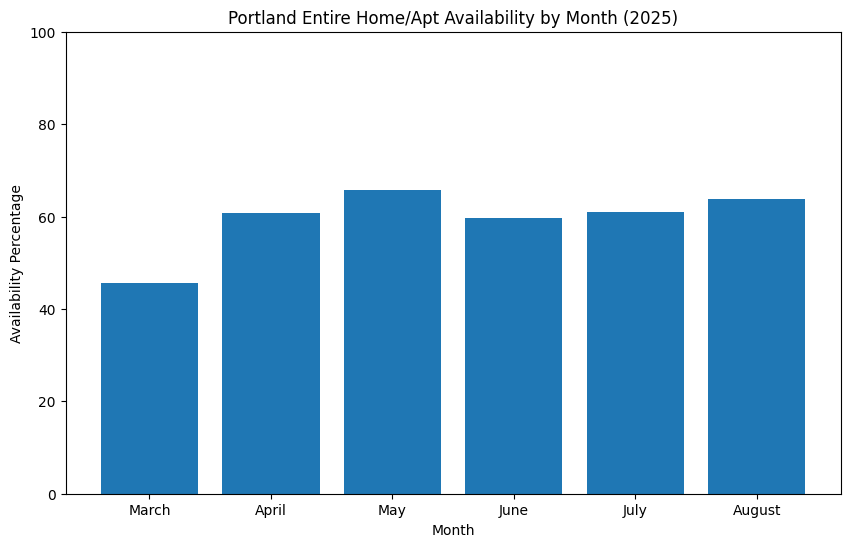

In [78]:
portland_homes_query = "SELECT id FROM listings WHERE city = 'Portland' AND room_type = 'Entire home/apt' ALLOW FILTERING"
portland_homes = session.execute(portland_homes_query)
portland_home_ids = [row.id for row in portland_homes]

start_month = 3  
end_month = 8    
year = 2025

monthly_availability = {month: 0 for month in range(start_month, end_month + 1)}
monthly_total = {month: 0 for month in range(start_month, end_month + 1)}

for listing_id in portland_home_ids:
    start_date = f"{year}-{start_month:02d}-01"
    end_date = f"{year}-{end_month:02d}-31"
    
    avail_query = "SELECT date, available FROM calendar WHERE listing_id = %s AND date >= %s AND date <= %s ALLOW FILTERING"
    calendar_data = session.execute(avail_query, (listing_id, start_date, end_date))
    
    for row in calendar_data:
        date_str = str(row.date)
        month = int(date_str.split('-')[1])
        
        if start_month <= month <= end_month:
            monthly_total[month] += 1
            if row.available:
                monthly_availability[month] += 1

availability_percentage = {}
for month in monthly_availability:
    if monthly_total[month] > 0:
        availability_percentage[month] = (monthly_availability[month] / monthly_total[month]) * 100
    else:
        availability_percentage[month] = 0

month_names = {3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August'}
trend_data = []

for month in range(start_month, end_month + 1):
    trend_data.append({
        'Month': month_names[month],
        'Available Nights': monthly_availability[month],
        'Total Nights': monthly_total[month],
        'Availability %': round(availability_percentage[month], 2)
    })

trend_df = pd.DataFrame(trend_data)
display(trend_df)


import matplotlib.pyplot as plt
    
plt.figure(figsize=(10, 6))
plt.bar(trend_df['Month'], trend_df['Availability %'])
plt.title('Portland Entire Home/Apt Availability by Month (2025)')
plt.ylabel('Availability Percentage')
plt.xlabel('Month')
plt.ylim(0, 100)
plt.show()

# Query 5: Booking trend, by city

Found 4542 listings in Portland
Found 45031 listings in Los Angeles
Found 45031 listings in Los Angeles
Found 354 listings in Salem
Found 354 listings in Salem
Found 12844 listings in San Diego
Found 12844 listings in San Diego


,City,Total Listings,Total Reviews (Dec 2023),Average Reviews per Listing
1,Los Angeles,45031,21250,0.47
3,San Diego,12844,11198,0.87
0,Portland,4542,4195,0.92
2,Salem,354,250,0.71


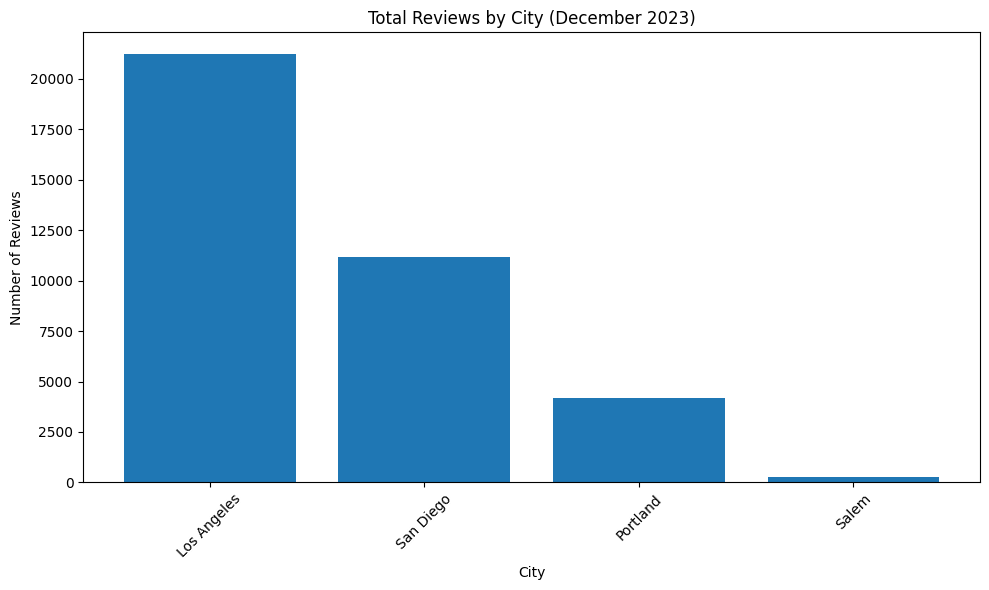

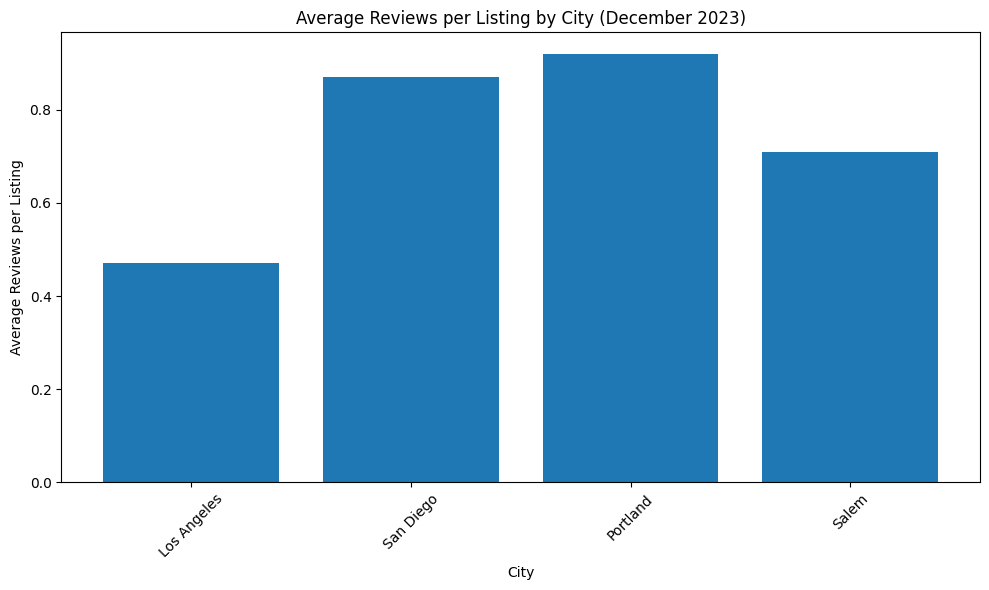

In [80]:
# Define the cities we want to analyze
target_cities = ["Portland", "Los Angeles", "Salem", "San Diego"]

# Define the analysis month
target_year = 2023
target_month = 12
start_date = f"{target_year}-{target_month:02d}-01"
end_date = f"{target_year}-{target_month:02d}-31"

# Dictionary to store review counts by city
city_reviews = {city: 0 for city in target_cities}
city_listings = {city: 0 for city in target_cities}

# Step 1 & 3: Get all listings by city and count reviews for December
for city in target_cities:
    # Get all listings in this city
    listings_query = "SELECT id FROM listings WHERE city = %s ALLOW FILTERING"
    city_listings_result = session.execute(listings_query, (city,))
    listing_ids = [row.id for row in city_listings_result]
    city_listings[city] = len(listing_ids)
    print(f"Found {len(listing_ids)} listings in {city}")
    
    # Step 2: Fetch reviews for December for each listing
    for listing_id in listing_ids:
        reviews_query = "SELECT date, id FROM reviews WHERE listing_id = %s AND date >= %s AND date <= %s ALLOW FILTERING"
        reviews_data = session.execute(reviews_query, (listing_id, start_date, end_date))
        
        # Count reviews for this listing
        review_count = len([row for row in reviews_data])
        city_reviews[city] += review_count

# Calculate average reviews per listing
avg_reviews_per_listing = {}
for city in target_cities:
    if city_listings[city] > 0:
        avg_reviews_per_listing[city] = city_reviews[city] / city_listings[city]
    else:
        avg_reviews_per_listing[city] = 0

# Convert to dataframe for display
trend_data = []
for city in target_cities:
    trend_data.append({
        'City': city,
        'Total Listings': city_listings[city],
        'Total Reviews (Dec 2023)': city_reviews[city],
        'Average Reviews per Listing': round(avg_reviews_per_listing[city], 2)
    })

trend_df = pd.DataFrame(trend_data)
# Sort by total reviews (descending)
trend_df = trend_df.sort_values(by='Total Reviews (Dec 2023)', ascending=False)
display(trend_df)

# Optional: Create a simple bar chart to visualize the trend
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.bar(trend_df['City'], trend_df['Total Reviews (Dec 2023)'])
    plt.title('Total Reviews by City (December 2023)')
    plt.ylabel('Number of Reviews')
    plt.xlabel('City')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Second chart for average reviews per listing
    plt.figure(figsize=(10, 6))
    plt.bar(trend_df['City'], trend_df['Average Reviews per Listing'])
    plt.title('Average Reviews per Listing by City (December 2023)')
    plt.ylabel('Average Reviews per Listing')
    plt.xlabel('City')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("Matplotlib not installed. Skipping chart visualization.")

# Query 6: Reminder to book again

Found 4542 listings in Portland


,reviewer_id,reviewer_name,listing_id,listing_name,review_month,recommendation_type
0,425576747,Rebecca,21439433,"Portland Classic - Parks, Eateries + Local Shops",10,Same listing is available again
1,425576747,Rebecca,1351601353530137088,La Casa Blanca - Sleeps 14 - 95 Walkscore,10,Similar listing by same host
2,425576747,Rebecca,45869511,"The Bohemian Spirit - Live Music, Eateries + Bars",10,Similar listing by same host
3,425576747,Rebecca,25052019,Modern Hawthorne Studio - Food Carts & Local S...,10,Similar listing by same host
4,425576747,Rebecca,46374482,Historic Mississippi - Live Music & Local Shops,10,Similar listing by same host
...,...,...,...,...,...,...
271,56661385,Sharon,2950282,Portland Cottage with Kitchenette,05,Same listing is available again
272,6991028,Frances,41839542,Fireplace Flat private 725 Sq Ft apt near U of P,05,Same listing is available again
273,278942780,James,48676845,Super Large Centrally located house,04,Same listing is available again
274,278942780,James,34355963,Centrally located house for large group,04,Similar listing by same host


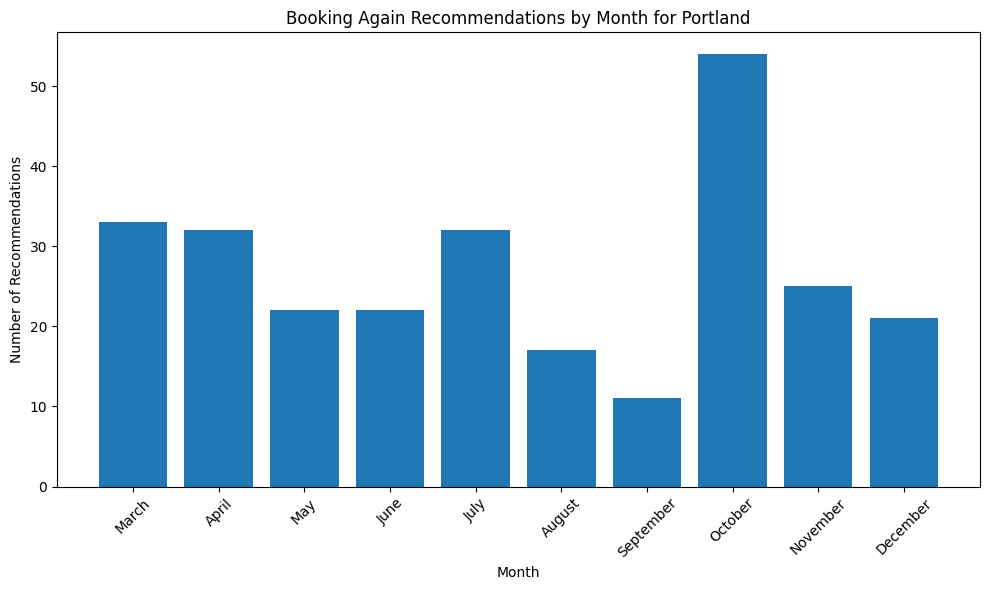

In [82]:
# Define target city and year for analysis
target_city = "Portland"
target_year = 2023

# Step 1: Get all listings in the target city
city_listings_query = "SELECT id, name, host_id FROM listings WHERE city = %s ALLOW FILTERING"
city_listings_result = session.execute(city_listings_query, (target_city,))
city_listings = [(row.id, row.name, row.host_id) for row in city_listings_result]
print(f"Found {len(city_listings)} listings in {target_city}")

# Dictionary to store reviewers who reviewed a listing more than once in the same month
repeat_reviewers = {}

# Step 2 & 3: Find reviewers who reviewed the same listing more than once in the same month
for listing_id, listing_name, host_id in city_listings:
    # Get reviews for this listing in the target year
    start_date = f"{target_year}-01-01"
    end_date = f"{target_year}-12-31"
    reviews_query = "SELECT date, reviewer_id, reviewer_name FROM reviews WHERE listing_id = %s AND date >= %s AND date <= %s ALLOW FILTERING"
    reviews_data = session.execute(reviews_query, (listing_id, start_date, end_date))
    
    # Group reviews by reviewer and month
    reviews_by_reviewer_month = {}
    for row in reviews_data:
        reviewer_id = row.reviewer_id
        date_str = str(row.date)
        month = date_str.split('-')[1]  # Extract month part (MM)
        
        # Create a key for reviewer and month
        reviewer_month_key = (reviewer_id, month)
        
        if reviewer_month_key not in reviews_by_reviewer_month:
            reviews_by_reviewer_month[reviewer_month_key] = {
                'count': 1,
                'reviewer_name': row.reviewer_name,
                'month': month
            }
        else:
            reviews_by_reviewer_month[reviewer_month_key]['count'] += 1
    
    # Find reviewers with multiple reviews in the same month
    for (reviewer_id, month), review_data in reviews_by_reviewer_month.items():
        if review_data['count'] > 1:
            key = (reviewer_id, review_data['reviewer_name'])
            if key not in repeat_reviewers:
                repeat_reviewers[key] = []
            
            # Check if the listing is available in the same month this year
            current_year = 2025  # Current year from context
            current_month = month
            avail_start = f"{current_year}-{current_month}-01"
            avail_end = f"{current_year}-{current_month}-28"  # Using 28 for simplicity across all months
            
            avail_query = "SELECT date FROM calendar WHERE listing_id = %s AND date >= %s AND date <= %s AND available = true ALLOW FILTERING"
            avail_data = session.execute(avail_query, (listing_id, avail_start, avail_end))
            is_available = len([row for row in avail_data]) > 0
            
            repeat_reviewers[key].append({
                'listing_id': listing_id,
                'listing_name': listing_name,
                'host_id': host_id,
                'review_month': month,
                'review_count': review_data['count'],
                'currently_available': is_available
            })

# Step 4 & 6: For each repeat reviewer, find other listings from the same hosts
recommendations = []

for (reviewer_id, reviewer_name), listings in repeat_reviewers.items():
    for listing_data in listings:
        if listing_data['currently_available']:
            # This listing is available in the same month as the previous review - direct recommendation
            recommendations.append({
                'reviewer_id': reviewer_id,
                'reviewer_name': reviewer_name,
                'listing_id': listing_data['listing_id'],
                'listing_name': listing_data['listing_name'],
                'review_month': listing_data['review_month'],
                'recommendation_type': 'Same listing is available again'
            })
        
        # Find other listings by the same host
        host_listings_query = "SELECT id, name FROM listings WHERE host_id = %s AND city = %s ALLOW FILTERING"
        host_listings = session.execute(host_listings_query, (listing_data['host_id'], target_city))
        
        # Check availability for the host's other listings
        current_year = 2025
        current_month = listing_data['review_month']
        avail_start = f"{current_year}-{current_month}-01"
        avail_end = f"{current_year}-{current_month}-28"
        current_listing_id = listing_data['listing_id']
        
        for row in host_listings:
            other_listing_id = row.id
            other_listing_name = row.name
            
            # Skip the original listing (we already recommended it if available)
            if other_listing_id == current_listing_id:
                continue
                
            # Check if this other listing is available in the target month
            avail_query = "SELECT date FROM calendar WHERE listing_id = %s AND date >= %s AND date <= %s AND available = true ALLOW FILTERING"
            avail_data = session.execute(avail_query, (other_listing_id, avail_start, avail_end))
            is_available = len([row for row in avail_data]) > 0
            
            if is_available:
                recommendations.append({
                    'reviewer_id': reviewer_id,
                    'reviewer_name': reviewer_name,
                    'listing_id': other_listing_id,
                    'listing_name': other_listing_name,
                    'review_month': listing_data['review_month'],
                    'recommendation_type': 'Similar listing by same host'
                })

# Display results
recommendations_df = pd.DataFrame(recommendations)
if not recommendations_df.empty:
    # Deduplicate recommendations (a reviewer might get the same listing recommended multiple times)
    recommendations_df = recommendations_df.drop_duplicates(subset=['reviewer_id', 'listing_id'])
    display(recommendations_df)
else:
    print("No recommendations found for repeat bookings.")

# Optional: Visualize recommendation counts by month
try:
    if not recommendations_df.empty:
        import matplotlib.pyplot as plt
        
        # Mapping month numbers to names
        month_names = {
            '01': 'January', '02': 'February', '03': 'March', '04': 'April',
            '05': 'May', '06': 'June', '07': 'July', '08': 'August', 
            '09': 'September', '10': 'October', '11': 'November', '12': 'December'
        }
        
        # Count recommendations by month
        recommendations_df['month_name'] = recommendations_df['review_month'].map(month_names)
        month_counts = recommendations_df.groupby('month_name').size().reset_index(name='count')
        
        # Sort by month order
        month_order = {name: i for i, name in enumerate(month_names.values())}
        month_counts['month_order'] = month_counts['month_name'].map(month_order)
        month_counts = month_counts.sort_values('month_order')
        
        plt.figure(figsize=(10, 6))
        plt.bar(month_counts['month_name'], month_counts['count'])
        plt.title(f'Booking Again Recommendations by Month for {target_city}')
        plt.ylabel('Number of Recommendations')
        plt.xlabel('Month')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
except Exception as e:
    print(f"Skipping visualization: {e}")